Código para 3 condiciones (Crtl, Mib, Iono)

In [48]:
#main_dir = r"E:\ADATA HD710 PRO\20250528 Adan"
# main_dir = 'C:\\Users\\aDo\\Documents\\RodrigoEscobedoTemporal'

import os
main_dir = os.path.join(os.path.expanduser("~"), "F:", "20250612 Adan")
print(os.listdir(main_dir))

# Diccionario con tus condiciones (carpetas dentro de main_dir)
datasets = {
    "ctr": "Exp3_CTRL",
    "mib1": "Exp3_CTRL_MIB",
    "iono": "Exp3_CTRL_IONO",
}

experiment_name = "20250612_M4_cells3"

['Exp3b_CTRL', 'Exp3b_CTRL_IONO', 'Exp3b_CTRL_MIB', 'Exp3b_NED', 'Exp3b_NED_IONO', 'Exp3b_NED_MIB', 'Exp3c_CTRL', 'Exp3c_CTRL_IONO', 'Exp3c_CTRL_MIB', 'Exp3c_NED', 'Exp3c_NED_IONO', 'Exp3c_NED_MIB', 'Exp3_CTRL', 'Exp3_CTRL_IONO', 'Exp3_CTRL_MIB', 'Exp3_NED', 'Exp3_NED_IONO', 'Exp3_NED_MIB']


In [49]:
tif_path = os.path.join(main_dir, experiment_name)
print(tif_path)
print(main_dir)

F:20250612 Adan\20250612_M4_cells3
F:20250612 Adan


In [50]:
import os
import tifffile
import dask.array as da
import numpy as np
import matplotlib.pyplot as plt
import shutil

from skimage.registration import phase_cross_correlation
from scipy.ndimage import shift

In [51]:
from dask import delayed

def load_tiff_stack(tiff_folder):
    """
    Carga una secuencia de imágenes TIFF desde una carpeta como Dask array 5D (T, C, Z, Y, X),
    compatible con formato OME-Zarr. Usa carga diferida (delayed) para evitar problemas de memoria.
    """
    # Obtener lista ordenada de archivos .tif/.tiff
    tiff_files = sorted([
        os.path.join(tiff_folder, f)
        for f in os.listdir(tiff_folder)
        if f.lower().endswith(('.tif', '.tiff'))
    ])

    print(f"Found {len(tiff_files)} TIFF files in {tiff_folder}.")

    if len(tiff_files) == 0:
        raise FileNotFoundError(f"No TIFF files found in folder: {tiff_folder}")

    # Obtener forma y tipo de datos a partir de la primera imagen
    sample = tifffile.imread(tiff_files[0])
    img_shape = sample.shape
    img_dtype = sample.dtype

    # Crear lista de arreglos diferidos
    lazy_arrays = [delayed(tifffile.imread)(f) for f in tiff_files]
    lazy_dask_arrays = [da.from_delayed(arr, shape=img_shape, dtype=img_dtype) for arr in lazy_arrays]

    # Apilar (T, Y, X)
    stack = da.stack(lazy_dask_arrays)

    # Expandir a (T, C=1, Z=1, Y, X)
    stack = stack[:, None, None, :, :]

    return stack

def plot_mean_projection_with_grid(stack, t_range, step=25, saturation_percentile=99.9, display_plot = True):
    """
    Compute and display a mean projection over time from a 5D stack with overlaid grid lines.

    Parameters:
        stack (dask.array): Input array with shape (T, C, Z, Y, X)
        t_range (tuple): Time indices (start, end) for projection
        step (int): Grid line spacing in pixels
        saturation_percentile (float): Upper percentile for intensity saturation
    """
    # Compute mean projection over time
    t_start, t_end = t_range
    mean_projection = stack[t_start:t_end, 0, 0].mean(axis=0).compute()  # shape (Y, X)

    # Define grid lines
    height, width = mean_projection.shape
    v_lines = range(0, width, step)
    h_lines = range(0, height, step)

    # Compute saturation limit
    vmax = np.percentile(mean_projection, saturation_percentile)

    # Plotting
    if display_plot:
      fig, ax = plt.subplots(1, 1, figsize=(6, 6))  # square plot
      ax.imshow(mean_projection, cmap='gray', vmax=vmax)
      ax.set_title("Mean Projection Over Time")

      for x in v_lines:
          ax.axvline(x=x, color='white', linestyle='--', linewidth=0.5)
      for y in h_lines:
          ax.axhline(y=y, color='white', linestyle='--', linewidth=0.5)

      ax.set_xlabel('X')
      ax.set_ylabel('Y')
      ax.set_aspect('equal')

      plt.tight_layout()
      plt.show()
    return mean_projection

# --- Signal mask function based on fixed background ---
def compute_signal_mask(image, background_level=130, threshold_factor=1.1):
    """
    Generate a binary mask of signal regions above background threshold.

    Parameters:
        image (ndarray): 2D image (Y, X)
        background_level (float): Approximate background intensity
        threshold_factor (float): Multiplier to set signal threshold

    Returns:
        mask (ndarray): Binary mask (True = signal)
    """
    threshold = threshold_factor * background_level
    return image > threshold

# --- Registration function using masked images ---
def register_image_with_mask(moving, reference, mask_ref=None, mask_mov=None, upsample_factor=10):
    """
    Register 'moving' image to 'reference' image using masked phase correlation.

    Parameters:
        moving (ndarray): 2D image to register
        reference (ndarray): 2D reference image
        mask_ref (ndarray): Binary mask for reference (same shape)
        mask_mov (ndarray): Binary mask for moving (same shape)
        upsample_factor (int): Precision factor for subpixel registration

    Returns:
        aligned (ndarray): Registered image (same shape)
        shift_vec (tuple): (dy, dx) subpixel shift vector
    """
    if mask_ref is not None:
        reference = reference * mask_ref
    if mask_mov is not None:
        moving = moving * mask_mov

    shift_vec, error, _ = phase_cross_correlation(reference, moving, upsample_factor=upsample_factor)
    aligned = shift(moving, shift=shift_vec, order=1, mode='nearest')
    return aligned, shift_vec

def visualize_roi_grid(stack, roi_center, roi_size=32, step=10):
    """
    Extracts and visualizes a ROI from a 5D stack with grid overlay.

    Parameters:
        stack (dask.array): Image stack with shape (T, C, Z, Y, X)
        roi_center (tuple): (x, y) coordinates for the ROI center
        roi_size (int): Half-size of ROI in pixels (ROI is 2*roi_size)
        step (int): Spacing between grid lines
    """
    x, y = roi_center
    rx = slice(x - roi_size, x + roi_size)
    ry = slice(y - roi_size, y + roi_size)

    # Extract ROI stack for all timepoints (assumes C=0, Z=0)
    roi_stack = stack[:, 0, 0][:, ry, rx].compute()  # shape: (T, Y, X)

    # Compute mean projection over time
    mean_projection = roi_stack.mean(axis=0)

    # Extract first frame
    first_image = roi_stack[0]

    height, width = first_image.shape
    v_lines = range(0, width, step)
    h_lines = range(0, height, step)

   # Plotting: only mean projection
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Mean projection
    ax.imshow(mean_projection, cmap='gray')
    ax.set_title("Mean Projection Over Time")

    for x in v_lines:
        ax.axvline(x=x, color='white', linestyle='--', linewidth=0.5)
    for y in h_lines:
        ax.axhline(y=y, color='white', linestyle='--', linewidth=0.5)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_aspect('equal')

    plt.tight_layout()
    plt.show()

def visualize_roi_grid_all_conditions(named_stacks, roi_centers, roi_size=32, step=10, t_range=(0, 49), saturation_percentile=99.9):
    """
    Visualize the same ROI across all conditions using their original stacks.

    Parameters:
        named_stacks (dict): Dictionary of Dask stacks with shape (T, C, Z, Y, X)
        roi_centers (dict): Dictionary of (x, y) centers per condition
        roi_size (int): Half-width of the ROI
        step (int): Grid spacing
        t_range (tuple): (start, end) time indices to use for mean projection
        saturation_percentile (float): Percentile for intensity saturation
    """
    condition_order = ['ctr', 'mib1', 'iono']
    fig, axes = plt.subplots(1, len(condition_order), figsize=(5 * len(condition_order), 5), squeeze=False)

    for i, condition in enumerate(condition_order):
        x, y = roi_centers[condition]
        rx = slice(int(x - roi_size), int(x + roi_size))
        ry = slice(int(y - roi_size), int(y + roi_size))

        stack = named_stacks[condition]
        t0, t1 = t_range
        roi_stack = stack[t0:t1, 0, 0, ry, rx].mean(axis=0).compute()  # shape: (Y, X)

        vmax = np.percentile(roi_stack, saturation_percentile)

        height, width = roi_stack.shape
        v_lines = range(0, width, step)
        h_lines = range(0, height, step)

        ax = axes[0][i]
        ax.imshow(roi_stack, cmap='gray', vmax=vmax)
        ax.set_title(f"{condition.upper()}")
        for xv in v_lines:
            ax.axvline(x=xv, color='white', linestyle='--', linewidth=0.5)
        for yv in h_lines:
            ax.axhline(y=yv, color='white', linestyle='--', linewidth=0.5)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_aspect('equal')

    plt.tight_layout()
    plt.show()

def align_mean_projections(mean_projections, ref_name = 'iono', background_level=130, step=25, saturation_percentile=99.9, display_plot= True):
    """
    Align mean projections to the 'iono' condition using masked registration.

    Parameters:
        mean_projections (dict): Dictionary with condition names as keys and 2D numpy arrays as values.
        background_level (int): Intensity threshold to define the background for signal masking.

    Returns:
        aligned_projections (dict): Dictionary of aligned projections.
        shifts (dict): Dictionary of shift vectors used for registration.
    """
    aligned_projections = {}
    shifts = {}

    # Define Reference
    ref_image = mean_projections[ref_name]
    mask_ref = compute_signal_mask(ref_image, background_level=background_level)

    for name, img in mean_projections.items():
        if name == 'iono':
            aligned_projections[name] = img
            shifts[name] = (0, 0)
            continue

        print(f"Registering {name} to IONO...")
        mask_img = compute_signal_mask(img, background_level=background_level)
        aligned_img, shift_vec = register_image_with_mask(
            moving=img,
            reference=ref_image,
            mask_ref=mask_ref,
            mask_mov=mask_img,
            upsample_factor=10
        )
        aligned_projections[name] = aligned_img

         # Plotting

        if display_plot:

          # Define grid lines
          height, width = aligned_img.shape
          v_lines = range(0, width, step)
          h_lines = range(0, height, step)

          # Compute saturation limit
          vmax = np.percentile(aligned_img, saturation_percentile)

          fig, ax = plt.subplots(1, 1, figsize=(6, 6))  # square plot
          ax.imshow(aligned_img, cmap='gray', vmax=vmax)
          ax.set_title("Mean Projection Over Time")

          for x in v_lines:
              ax.axvline(x=x, color='white', linestyle='--', linewidth=0.5)
          for y in h_lines:
              ax.axhline(y=y, color='white', linestyle='--', linewidth=0.5)

          ax.set_xlabel('X')
          ax.set_ylabel('Y')
          ax.set_aspect('equal')

          plt.tight_layout()
          plt.show()



        shifts[name] = shift_vec
        print(f"{name} registered with shift: {shift_vec}")

    return aligned_projections, shifts

def load_and_register_stacks(datasets, main_dir, t_range=(0, 49), grid_step=25, saturation_percentile=99.9, ref_name='iono', background_level=130,  display_grid_plot=False):
    """
    Load TIFF stacks for all experimental conditions, compute mean projections, and align them to a reference.

    Parameters:
        datasets (dict): Dictionary mapping condition names to folder names.
        main_dir (str): Path to the directory containing all dataset folders.
        t_range (tuple): Temporal range for mean projection computation.
        grid_step (int): Grid step size for visualization (used in projection plotting).
        saturation_percentile (float): Percentile used to clip high intensities in visualization.
        ref_name (str): Name of the condition to use as reference for alignment.
        background_level (int): Threshold to compute binary masks for registration.

    Returns:
        stacks (dict): Dictionary with condition names as keys and TIFF stacks as values.
        shifts (dict): Dictionary with condition names as keys and shift vectors as values.
    """
    stacks = {}

    # Load all TIFF stacks
    for condition, folder_name in datasets.items():
        tiff_folder = os.path.join(main_dir, folder_name)
        print(f"{condition}: {tiff_folder}")
        stacks[condition] = load_tiff_stack(tiff_folder)  # expected shape: (T, C, Z, Y, X)

    # Compute mean projections
    mean_projections = {}
    for condition, stack in stacks.items():
        print(f"Processing mean projection for: {condition}")
        mean_projections[condition] = plot_mean_projection_with_grid(
            stack,
            t_range,
            grid_step,
            saturation_percentile,
            display_grid_plot
        )

    # Align mean projections to reference
    _, shifts = align_mean_projections(
        mean_projections,
        ref_name=ref_name,
        background_level=background_level,
        step=grid_step,
        saturation_percentile=saturation_percentile,
        display_plot=False
    )

    return stacks, shifts


def save_as_ometiff(data, output_path):
    """
    Save a 5D stack (T, C, Z, Y, X) as a single OME-TIFF file.

    Parameters:
        data (np.ndarray or dask.array): Array with shape (T, C, Z, Y, X)
        output_path (str): Path to output .ome.tif file
    """
    if hasattr(data, "compute"):
        data = data.compute()

    # Rearrange axes to (T, Z, C, Y, X) as expected by tifffile
    if data.ndim == 5:
        data = data.transpose(0, 2, 1, 3, 4)  # (T, Z, C, Y, X)

    tifffile.imwrite(
        output_path,
        data,
        photometric='minisblack',
        metadata={'axes': 'TZCYX'},
        ome=True,
        bigtiff=True
    )

def save_rois_as_tif(stacks, rois, shifts, roi_size, tif_path, t_range=(None, None)):
    """
    Save each ROI and condition as an independent OME-TIFF image.
    If no time range is specified, the full temporal extent is used.
    """
    os.makedirs(tif_path, exist_ok=True)
    conditions = ['ctr', 'mib1', 'iono']

    for cond in conditions:
        print(f"\n[INFO] Processing condition: {cond}")
        stack = stacks[cond]

        # Definir rango temporal
        t0, t1 = t_range
        if t0 is None or t1 is None:
            t0 = 0
            t1 = stack.shape[0]  # use full time range

        full_block = stack[t0:t1, :, :, :, :]  # (T, C, Z, Y, X)
        dx, dy = shifts[cond][1], shifts[cond][0]

        for i, (x, y, _, _) in enumerate(rois):
            adj_x, adj_y = x - dx, y - dy
            rx = slice(int(adj_x - roi_size), int(adj_x + roi_size))
            print(rx)
            ry = slice(int(adj_y - roi_size), int(adj_y + roi_size))
            print(ry)

            # Extraer ROI
            roi_stack = full_block[:, :, :, ry, rx]

            # Verificar si está vacía o fuera de límites
            if any(s == 0 for s in roi_stack.shape):
                print(roi_stack.shape)
                print(f"[WARNING] ROI {i} en {cond} está fuera de límites. Se omite.")
                continue

            tif_name = f"roi_{i:02d}_{cond}.ome.tif"
            tif_out_path = os.path.join(tif_path, tif_name)

            print(f"[INFO] Guardando {tif_name} con shape {roi_stack.shape} en:")
            print(f"       {tif_out_path}")

            # Guardar TIFF
            save_as_ometiff(roi_stack, tif_out_path)
            print(f"[SUCCESS] Archivo guardado: {tif_name}")

    print(f"\n[FINALIZADO] Todos los TIFFs fueron escritos en: {tif_path}")


def save_full_stacks_as_ometiff(stacks, out_dir):
    os.makedirs(out_dir, exist_ok=True)
    for cond, stack in stacks.items():
        out_file = os.path.join(out_dir, f"{cond}_fullstack.ome.tif")
        print(f"[SAVE] {cond} → {out_file}")
        save_as_ometiff(stack, out_file)
    print("[DONE] Stacks completos guardados.")


In [52]:
def save_as_ometiff(data, output_path):
    if hasattr(data, "compute"):
        data = data.compute()

    if data.ndim == 5:
        data = data.transpose(0, 2, 1, 3, 4)  # (T, Z, C, Y, X)

    tifffile.imwrite(
        output_path,
        data,
        photometric='minisblack',
        metadata={'axes': 'TZCYX'},
        ome=True,
        bigtiff=True
    )

ctr: F:20250612 Adan\Exp3_CTRL
Found 48001 TIFF files in F:20250612 Adan\Exp3_CTRL.
mib1: F:20250612 Adan\Exp3_CTRL_MIB
Found 48001 TIFF files in F:20250612 Adan\Exp3_CTRL_MIB.
iono: F:20250612 Adan\Exp3_CTRL_IONO
Found 48001 TIFF files in F:20250612 Adan\Exp3_CTRL_IONO.
Processing mean projection for: ctr


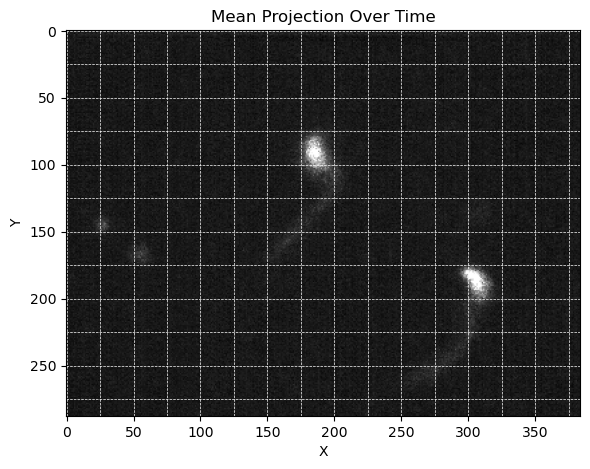

Processing mean projection for: mib1


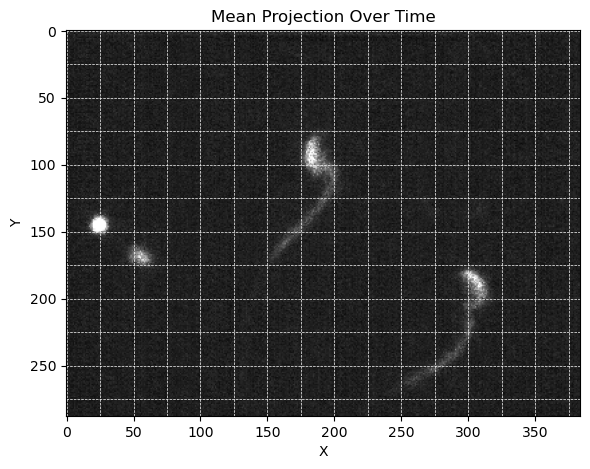

Processing mean projection for: iono


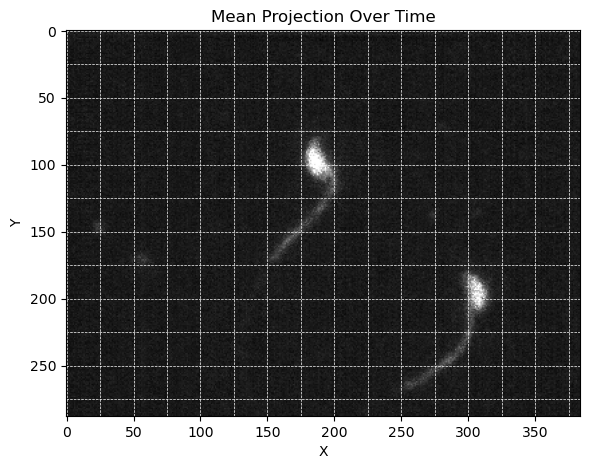

Registering ctr to IONO...
ctr registered with shift: [0.1 0. ]
Registering mib1 to IONO...
mib1 registered with shift: [-45.3 162.3]


In [53]:
# Parameters:
# - datasets: dictionary mapping condition names (e.g., 'ctr', 'mib1') to folder names.
# - main_dir: root directory where the TIFF folders are located.
# - t_range: time range (start, end) used to compute the mean projection for alignment.
# - grid_step: distance in pixels between grid lines overlaid on the projection (for visual QC).
# - saturation_percentile: intensity percentile used to limit display dynamic range in projections.
# - ref_name: experimental condition used as spatial reference for alignment (typically the iono conditions).
# - background_level: intensity threshold used to define the foreground mask for image registration.
# - display_grid_plot: whether to visualize the mean projections with overlaid grid during execution.

stacks, shifts = load_and_register_stacks(
    datasets=datasets,
    main_dir=main_dir,
    t_range=(0, 499),
    grid_step=25,
    saturation_percentile=99.9,
    ref_name='iono',
    background_level=130,
    display_grid_plot=True
)

# Output:
# - stacks: dictionary with condition names as keys and 5D image stacks (T, C, Z, Y, X) as values.
# - shifts: dictionary with condition names as keys and registration shift vectors (dy, dx) as values.

ROI 0: base center=(195, 100)


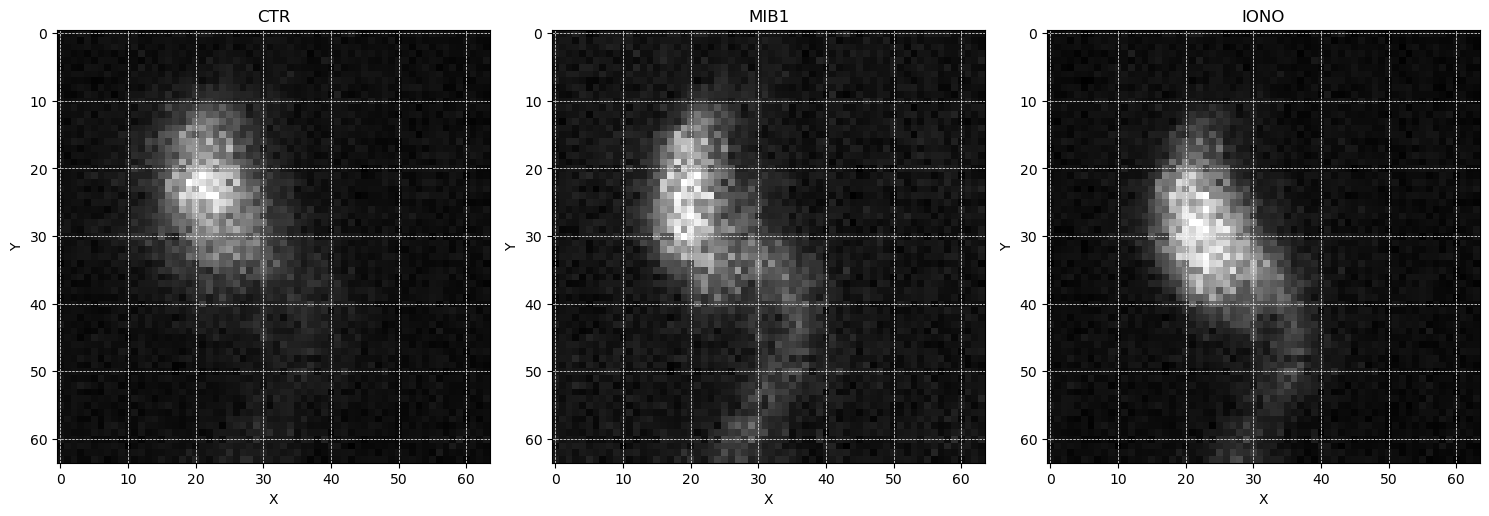

ROI 1: base center=(310, 200)


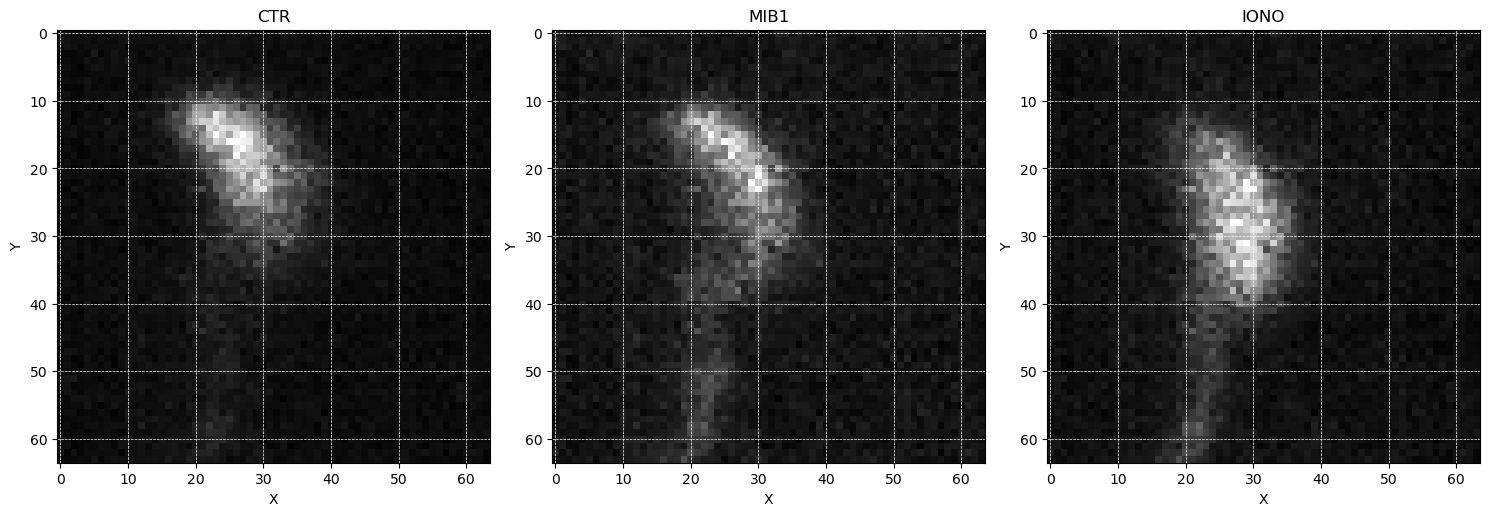

ROI 2: base center=(75, 100)


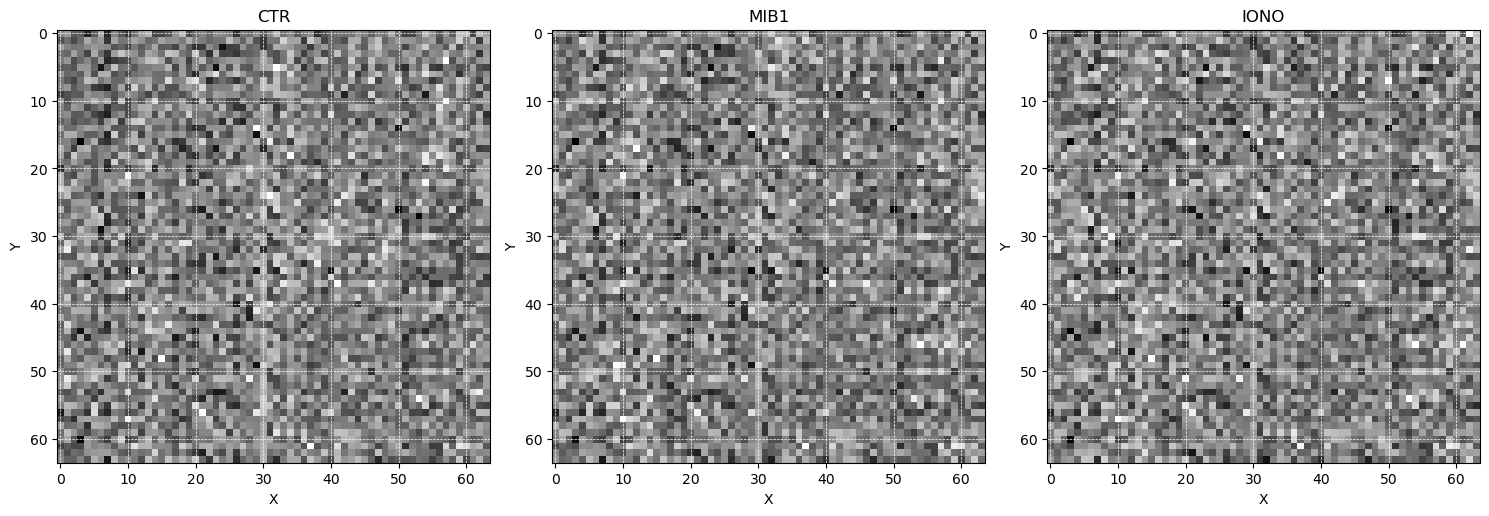

ROI 3: base center=(300, 100)


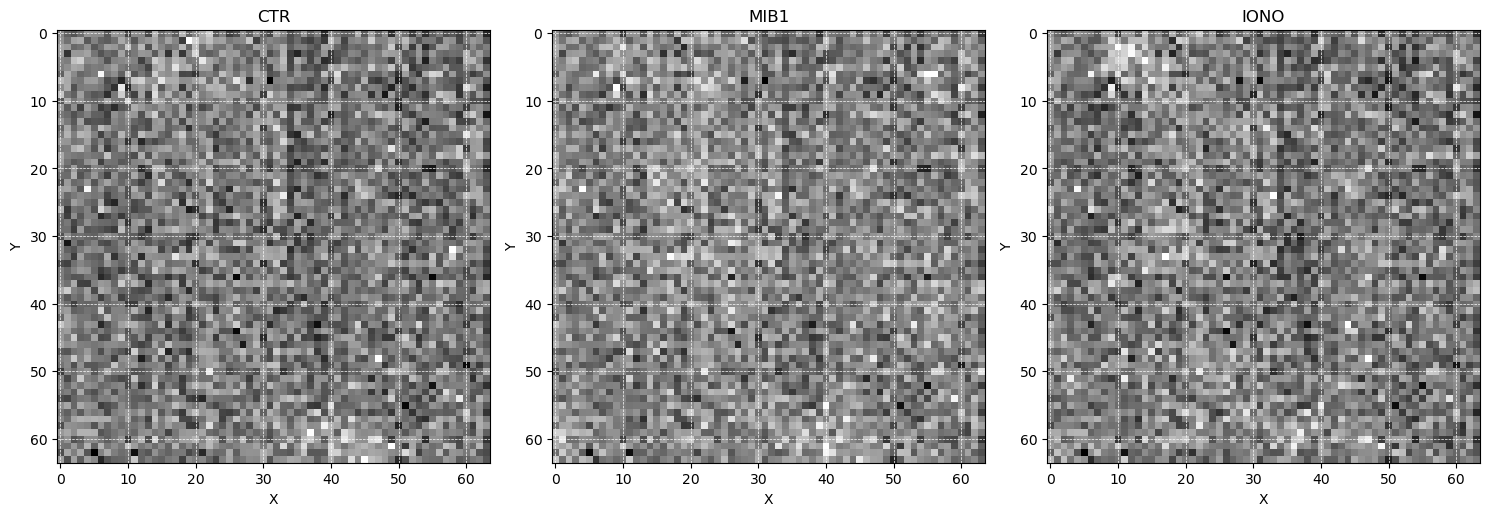

In [54]:
# --- Define ROIs manually ---
roi_size = 32

rois = [
    (195, 100, roi_size, roi_size),  # (x, y, width, height)
    (310, 200, roi_size, roi_size),
    (75, 100, roi_size, roi_size), ## background roi
    (300, 100, roi_size, roi_size), ## background roi
]
n_rois = len(rois)

# --- Visualize each ROI with grid overlay ---

for i, (x, y, _, _) in enumerate(rois):
    print(f"ROI {i}: base center=({x}, {y})")

    # Adjust center per condition using inverse shift
    adjusted_centers = {
        #cond: (x - shifts[cond][1], y - shifts[cond][0])  # shift = (dy, dx)
        cond: (x, y)  # shift = (dy, dx)
        for cond in ['ctr', 'mib1', 'iono']
    }

    visualize_roi_grid_all_conditions(stacks, roi_centers=adjusted_centers, roi_size=roi_size, step=10, t_range=(0, 499))

Guardando las ROIs en: C:\Users\ADMIN\Desktop\ROIs_refinadas\Sin_NED\Exp_20250612_Sin_NED\20250612_M4_cells3

[INFO] Processing condition: ctr
slice(163, 227, None)
slice(67, 131, None)
[INFO] Guardando roi_00_ctr.ome.tif con shape (250, 1, 1, 64, 64) en:
       C:\Users\ADMIN\Desktop\ROIs_refinadas\Sin_NED\Exp_20250612_Sin_NED\20250612_M4_cells3\roi_00_ctr.ome.tif
[SUCCESS] Archivo guardado: roi_00_ctr.ome.tif
slice(278, 342, None)
slice(167, 231, None)
[INFO] Guardando roi_01_ctr.ome.tif con shape (250, 1, 1, 64, 64) en:
       C:\Users\ADMIN\Desktop\ROIs_refinadas\Sin_NED\Exp_20250612_Sin_NED\20250612_M4_cells3\roi_01_ctr.ome.tif
[SUCCESS] Archivo guardado: roi_01_ctr.ome.tif
slice(43, 107, None)
slice(67, 131, None)
[INFO] Guardando roi_02_ctr.ome.tif con shape (250, 1, 1, 64, 64) en:
       C:\Users\ADMIN\Desktop\ROIs_refinadas\Sin_NED\Exp_20250612_Sin_NED\20250612_M4_cells3\roi_02_ctr.ome.tif
[SUCCESS] Archivo guardado: roi_02_ctr.ome.tif
slice(268, 332, None)
slice(67, 131, None

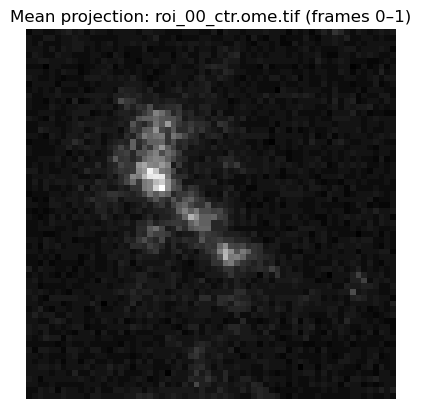

In [56]:
tif_path_base = r"C:\Users\ADMIN\Desktop\ROIs_refinadas\Sin_NED\Exp_20250612_Sin_NED"  # <-- tu ruta base
tif_path = os.path.join(tif_path_base, experiment_name)        # <--- subcarpeta por experimento
os.makedirs(tif_path, exist_ok=True)

print(f"Guardando las ROIs en: {tif_path}")

# --- Guardado de las ROIs ---
save_rois_as_tif(
    stacks=stacks,
    rois=rois,
    shifts=shifts,
    roi_size=32,
    tif_path=tif_path,
    t_range=(0, 250)  # ← Descomenta para guardar solo los primeros 50 cuadros
)

# --- (Opcional) Inspección rápida de lo guardado ---
tif_files = sorted([f for f in os.listdir(tif_path) if f.endswith('.ome.tif')])
print("Available OME-TIFF files:", tif_files)
if tif_files:
    file_to_use = tif_files[0]
    arr = tifffile.imread(os.path.join(tif_path, file_to_use))
    while arr.ndim < 5:
        arr = np.expand_dims(arr, axis=0)
    t_start, t_end = 0, min(49, arr.shape[0])
    subset = arr[t_start:t_end, 0, 0, :, :]
    mean_proj = np.mean(subset, axis=0)
    plt.imshow(mean_proj, cmap='gray')
    plt.title(f"Mean projection: {file_to_use} (frames {t_start}–{t_end})")
    plt.axis('off')
    plt.show()

In [42]:
rois

[(185, 100, 32, 32), (310, 200, 32, 32), (75, 100, 32, 32), (300, 100, 32, 32)]

In [43]:
shifts

{'ctr': array([0.1, 0. ]), 'mib1': array([-45.3, 162.3]), 'iono': (0, 0)}